### Loading the cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")

### Normalization

In [2]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler
from pandas import DataFrame

scaler = StandardScaler()

X = quant.values
X = scaler.fit_transform(X)
# DataFrame(X).boxplot()
# plt.xticks(range(1, 1+len(quant.columns)), labels=quant.columns, rotation=90)

### PCA

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


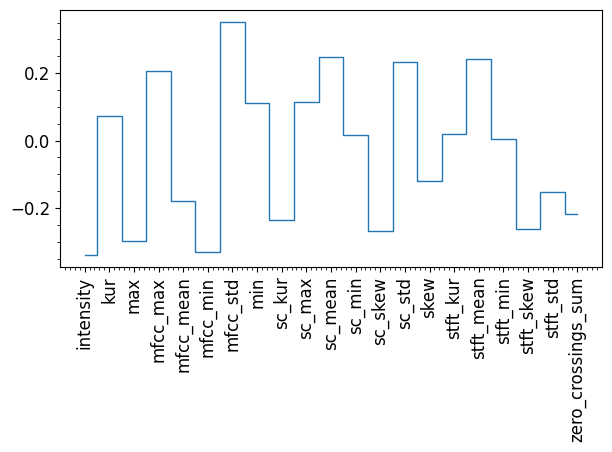

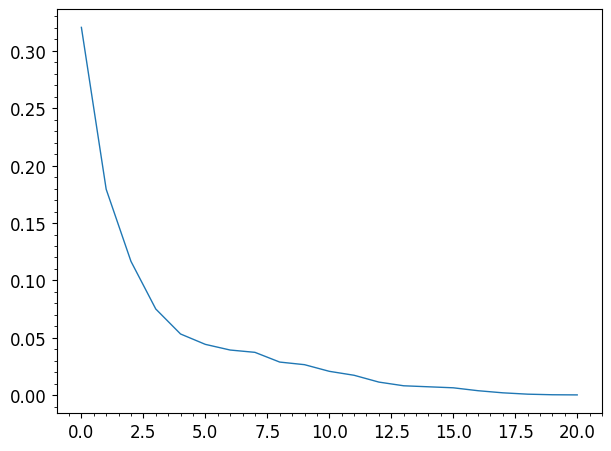

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X)
plt.step(range(len(pca.components_)), pca.components_[0], where="mid")
plt.xticks(range(len(pca.components_)), labels=quant.columns, rotation=90)
plt.figure(2)
plt.plot(pca.explained_variance_ratio_)


/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


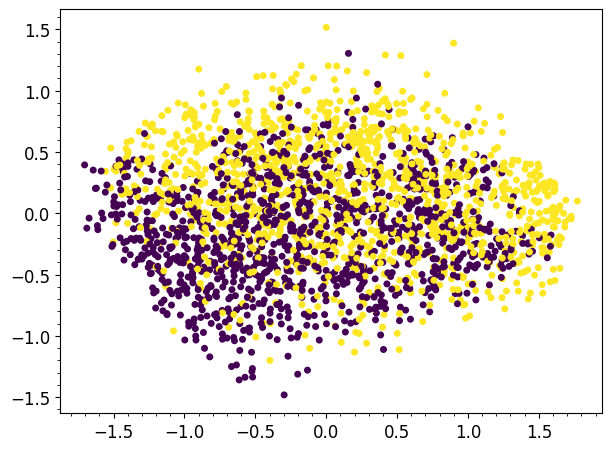

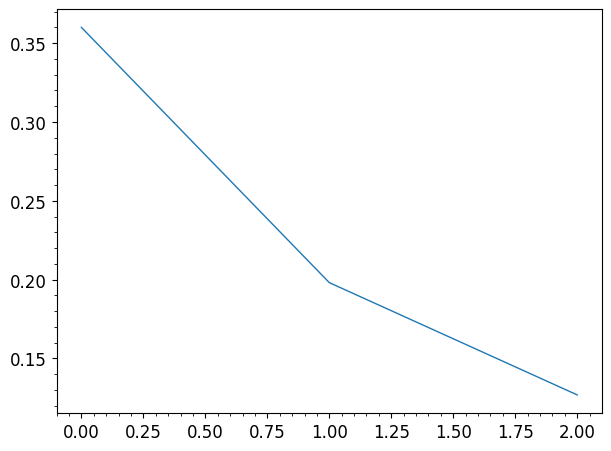

In [4]:
pca = PCA(n_components=3)
Y = QuantileTransformer().fit_transform(quant.values) + 1/len(quant)
Z = pca.fit_transform(Y)
plt.scatter(Z[:,0], Z[:,2] , c=pd.Categorical(categ.sex).codes)
plt.figure(2)
plt.plot(pca.explained_variance_ratio_)


Manifold knn representation

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


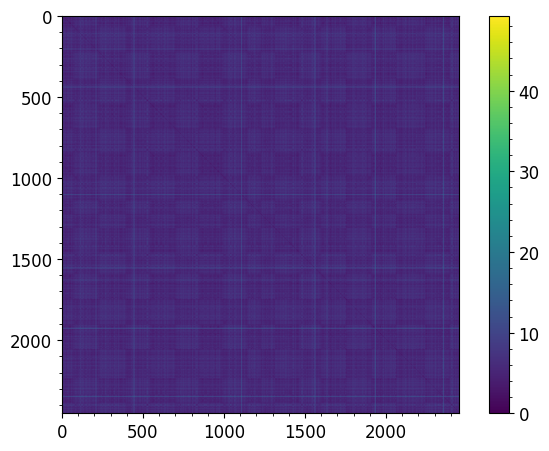

In [5]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
k = len(X)
A = kneighbors_graph(X,k, mode='distance', include_self=True)
adj = A.toarray()
plt.imshow(adj)
plt.colorbar()

This shows that the distances in the male subgroup are smaller than the inter-group average distance.

In [6]:
from sklearn.manifold import MDS
# For MDS is wiset to use Quantiles
X = quant.values
X = QuantileTransformer().fit_transform(X)
embedding = MDS(n_components=2, metric=True).fit_transform(X)

Text(0.5, 0.98, 'MultiDimensional Scaling')

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


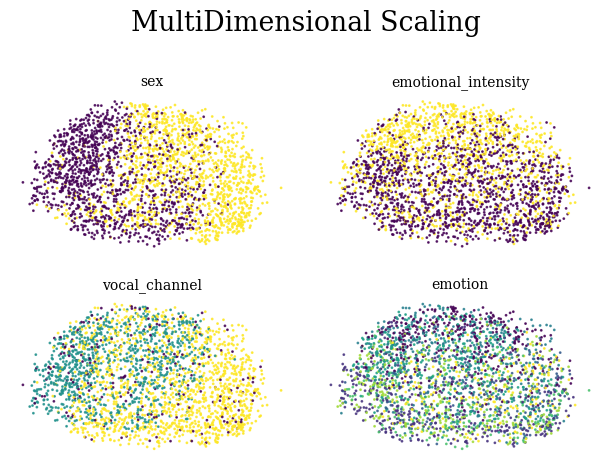

In [7]:
fig, axes = plt.subplots(2,2)
axes = axes.flatten()
fields = ["sex", "emotional_intensity", "vocal_channel", "emotion"]
for ax, field in zip(axes, fields):
    ax.scatter(embedding[:,0], embedding[:,1], c=pd.Categorical(categ[field]).codes, s=1, alpha=0.8)
    ax.set_title(field, font={"size":10, "family":"serif"})
    ax.axis("off")
fig.suptitle("MultiDimensional Scaling", font={ "family":"serif"})

# UMAP

(-2.9380428791046143,
 11.700563669204712,
 1.537529069185257,
 10.639897388219833)

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


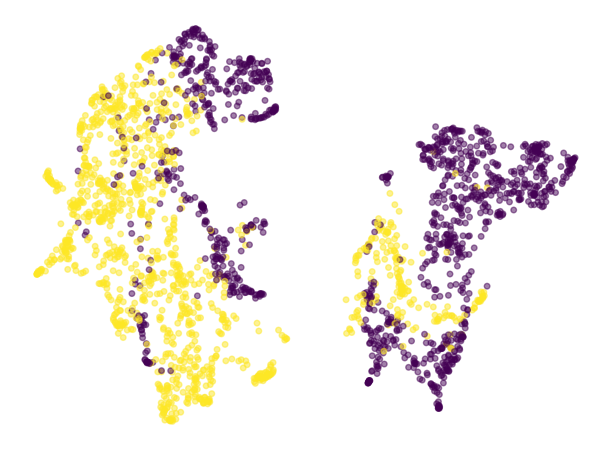

In [8]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
import umap 

X = quant.values
scaler = StandardScaler() # MinMaxScaler()
X = scaler.fit_transform(X)
reducer = umap.UMAP(n_neighbors=20)
embedding = reducer.fit_transform(X)
plt.scatter(embedding[:,0], embedding[:,1], c=pd.Categorical(categ.sex).codes, alpha=0.5)
plt.axis("off")

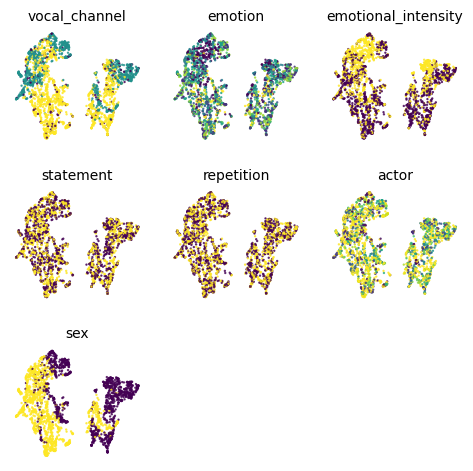

In [9]:
fig, axes = plt.subplots(3,3 , figsize=(5,5))
axes = axes.flatten()

for ax in axes:
    ax.axis("off")

for i in range(len(axes)):
    if i < len(categ.columns):
        axes[i].scatter(embedding[:,0], embedding[:,1], c=pd.Categorical(categ[categ.columns[i]]).codes, alpha=0.8, s=0.5)
        axes[i].set_title(f"{categ.columns[i]}", font={"size":10})


We drop the analysis of `repetition`, `actor` and `statement` by now

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


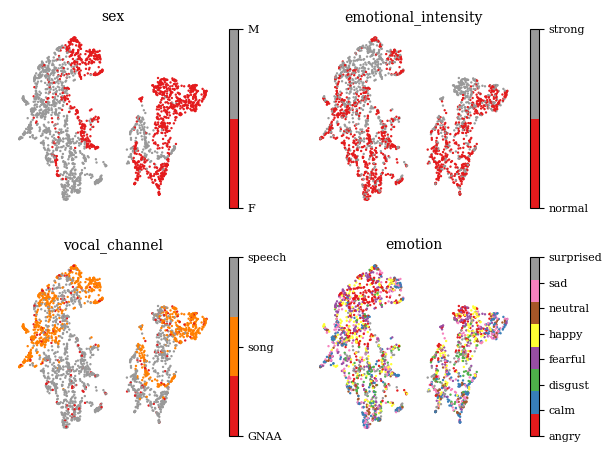

In [10]:
from matplotlib import cm

good_ones = ["sex", "emotional_intensity", "vocal_channel", "emotion"]

fig, axes = plt.subplots(2,2)
axes = axes.flatten()

for ax, cat in zip(axes, good_ones):
    labels = pd.Categorical(categ[cat]).categories
    cmap = cm.get_cmap("Set1", len(labels))
    mappable = ax.scatter(embedding[:,0], embedding[:,1], c=pd.Categorical(categ[cat]).codes,
                cmap=cmap, alpha=1.0, s=0.5)
    ax.set_title(f"{cat}", font={"size":10, "family":"serif"})
    cbar = fig.colorbar(mappable, ax=ax)
    cbar.ax.set_yticks(range(len(labels)))
    cbar.ax.set_yticklabels(labels, font={"size":8, "family":"serif"})
    cbar.ax.tick_params(axis='y', which='minor', right=False)
    ax.axis("off")
fig.tight_layout()
plt.savefig("UMAP.pdf")


## ISOMAP and Minkowski _p_

It can be seen that when $p=1$ ISOMAP shows a big unique spot while when $p=\infty$ even isomap shows two distinct topological areas _even with a standard scaler_


/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


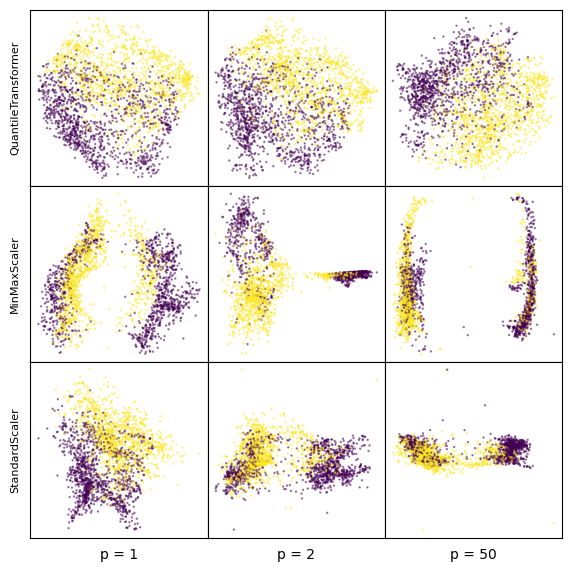

In [11]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler
from sklearn.manifold import Isomap

scalers = [QuantileTransformer(), MinMaxScaler(), StandardScaler()]
ps = [1,2,50]

fig, axes = plt.subplots(len(scalers),len(ps), figsize=(6,6),gridspec_kw = {'wspace':0, 'hspace':0})

for i, scaler in enumerate(scalers):
    for j, p in enumerate(ps):
        X = quant.values
        X = scaler.fit_transform(X)
        S = Isomap(n_neighbors=5, p=p).fit_transform(X)
        axes[i,j].scatter(S[:,0], S[:,1], c=pd.Categorical(categ.sex).codes, alpha=0.5, s=0.5)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        
        if j == 0:
            axes[i,j].set_ylabel(str(scaler.__class__).split(".")[-1][:-2], font={"size":8})
        if i==2:
            axes[i,j].set_xlabel(f"p = {p}", font={"size":10})
        # axes[i,j].axis("off")
plt.show()